In [ ]:
!pip install Craft-xai captum grad-cam
!rm -rf ML4CV_XAI
!git clone https://github.com/liuktc/ML4CV_XAI.git

import sys
sys.path.append("/kaggle/working/ML4CV_XAI")

TO-DO

0) Better understand the results of craft, and why my multiplication dont match.
1) Calculate all the craft values for each class and for each model and save the results.
2) MOCO(https://arxiv.org/pdf/2306.06805) don't provide implementation.
3) Compare ResNet and VGG11. Show that craft works better with resnet. In VGG the heavy lifting is done by the fully connected layers, so the embeddings are not as good as in ResNet.

In [1]:
%load_ext autoreload

%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from data import PascalVOC2007
from models import vgg11_PascalVOC
from tqdm.auto import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
torch.manual_seed(123)
np.random.seed(123)

In [2]:
model = vgg11_PascalVOC()
model.to(device)
# Load the pretrained weights
model.load_state_dict(torch.load('VGG11_PascalVOC.pt', map_location=device))
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                 # Convert to Tensor
    transforms.Normalize(                  # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


In [3]:
test_data = PascalVOC2007("test", transform=preprocess)
# train_data = PascalVOC2007("trainval", transform=preprocess)

Using downloaded and verified file: data\VOCtest_06-Nov-2007.tar
Extracting data\VOCtest_06-Nov-2007.tar to data


In [4]:
import torch.nn as nn
g = nn.Sequential(*list(model.children())[:-1])
h = lambda x : model.classifier(torch.flatten(x, 1))

In [5]:
from torch.utils.data import Subset, DataLoader

NUM_IMAGES = 2000
BATCH_SIZE = 32

# Extract subset of NUM_IMAGES random images
indices = np.random.choice(len(test_data), NUM_IMAGES, replace=False)
subset = Subset(test_data, indices)

test_dl = DataLoader(subset, batch_size=32, shuffle=False)

In [ ]:
from utils import get_class_predictions_indices
CLASS_TO_EXPLAIN = 1

image_indices = get_class_predictions_indices(
        test_data, model, CLASS_TO_EXPLAIN, device
    ).to(device)

class_images = torch.tensor([]).to(device)
for i in image_indices:
    x, _ = test_data[i]
    x = x.to(device)
    class_images = torch.cat((class_images, x.unsqueeze(0)), dim=0)

If we want to explain a certain class, we don't take all the images with a certain labels, but all the images that the model predicted with a certain label. More formally, to explain a specific class $y$, we select all the image $C$ from the dataset such that:

$$ C = \{x_i: f(x_i) = y, 1 \leq i \leq n\} $$

Citing from the CRAFT paper: _It is important to emphasize that this choice is significant. The goal is not
to understand how humans labeled the data, but rather to comprehend the model itself. By only selecting correctly classified images, important biases and failure cases may be missed, preventing a complete understanding of our model._

In [ ]:
from craft.craft_torch import Craft, torch_to_numpy
from utils import calculate_craft_for_class

craft = Craft(input_to_latent = g,
              latent_to_logit = h,
              number_of_concepts = 10,
              patch_size = 56,
              batch_size = 32,
              device = "cpu")

crops, crops_u, w, importances, images_u = calculate_craft_for_class(craft, model, test_data, class_to_explain=CLASS_TO_EXPLAIN, device=device)

Calculating predictions for each image


  0%|          | 0/376 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
importances = craft.estimate_importance(class_images, class_id=CLASS_TO_EXPLAIN)
images_u = craft.transform(class_images)

images_u.shape

c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\craft\craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])
c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\craft\craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])


(54, 7, 7, 10)

Concept 8  has an importance value of  0.31442294
Concept 1  has an importance value of  0.17878619
Concept 4  has an importance value of  0.02572224
Concept 7  has an importance value of  0.024398012
Concept 5  has an importance value of  0.023780882


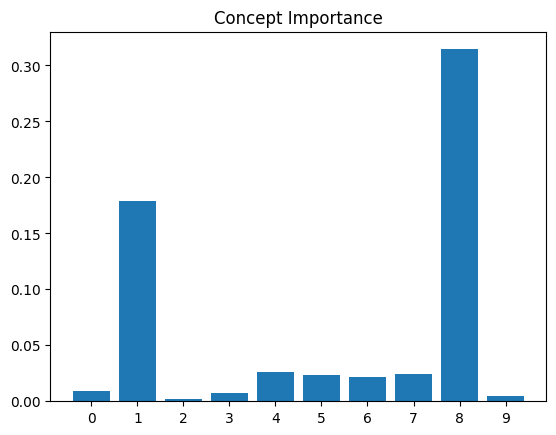

In [20]:
# We are done, let's inspect the results !
# first, lets see which concepts matter
import matplotlib.pyplot as plt

plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)))
plt.title("Concept Importance")

most_important_concepts = np.argsort(importances)[::-1][:5]

for c_id in most_important_concepts:
  print("Concept", c_id, " has an importance value of ", importances[c_id])

Concept 8  has an importance value of  0.31442294


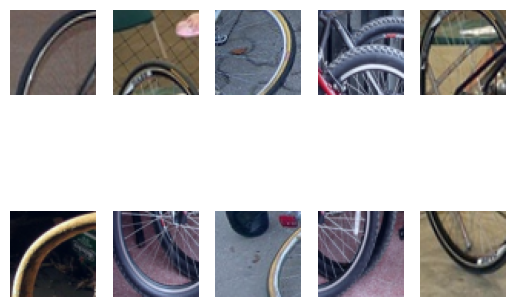




Concept 1  has an importance value of  0.17878619


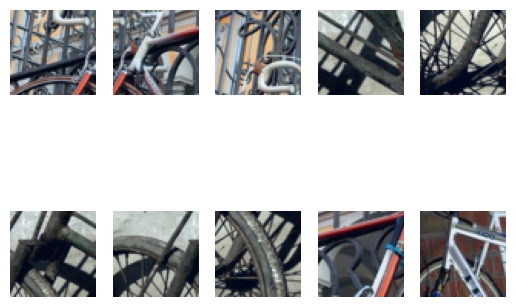




Concept 4  has an importance value of  0.02572224


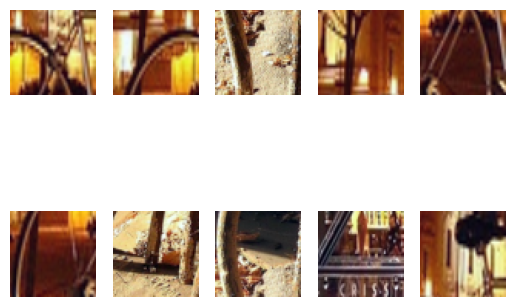




Concept 7  has an importance value of  0.024398012


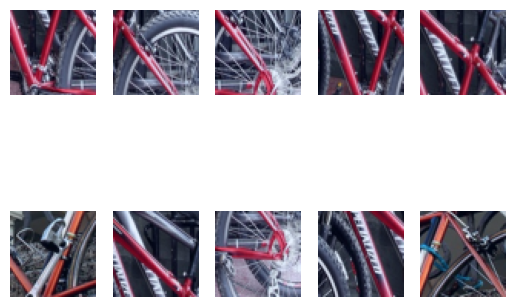




Concept 5  has an importance value of  0.023780882


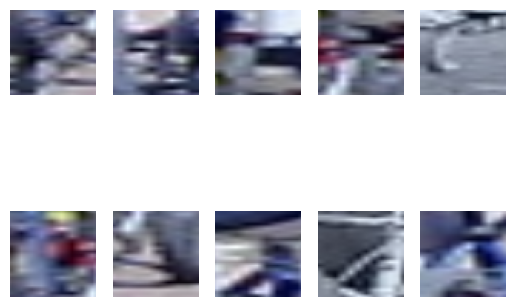

In [21]:
# Ok nice, let inspect those concepts by showing the 10 best crops for
# each concepts
from math import ceil
nb_crops = 10

def show(img, **kwargs):
  img = np.array(img)
  if img.shape[0] == 3:
    img = img.transpose(1, 2, 0)

  img -= img.min();img /= img.max()
  plt.imshow(img, **kwargs); plt.axis('off')

for c_id in most_important_concepts:

  best_crops_ids = np.argsort(crops_u[:, c_id])[::-1][:nb_crops]
  best_crops = crops[best_crops_ids]

  print("Concept", c_id, " has an importance value of ", importances[c_id])
  for i in range(nb_crops):
    plt.subplot(ceil(nb_crops/5), 5, i+1)
    show(best_crops[i])
  plt.show()
  print('\n\n')

In [22]:
from matplotlib.colors import ListedColormap
import matplotlib
import colorsys

def get_alpha_cmap(cmap):
  if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)
  else:
    c = np.array((cmap[0]/255.0, cmap[1]/255.0, cmap[2]/255.0))

    cmax = colorsys.rgb_to_hls(*c)
    cmax = np.array(cmax)
    cmax[-1] = 1.0

    cmax = np.clip(np.array(colorsys.hls_to_rgb(*cmax)), 0, 1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [c,cmax])

  alpha_cmap = cmap(np.arange(256))
  alpha_cmap[:,-1] = np.linspace(0, 0.85, 256)
  alpha_cmap = ListedColormap(alpha_cmap)

  return alpha_cmap

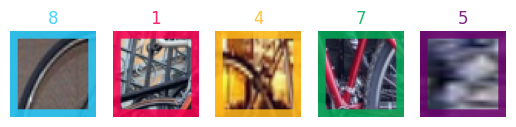

In [23]:
cmaps = [
  get_alpha_cmap((54, 197, 240)),
  get_alpha_cmap((210, 40, 95)),
  get_alpha_cmap((236, 178, 46)),
  get_alpha_cmap((15, 157, 88)),
  get_alpha_cmap((84, 25, 85))
]

def plot_legend():
  for i, c_id in enumerate(most_important_concepts):
    cmap = cmaps[i]
    plt.subplot(1, len(most_important_concepts), i+1)

    best_crops_id = np.argsort(crops_u[:, c_id])[::-1][0]
    best_crop = crops[best_crops_id]

    p = 5
    mask = np.zeros(best_crop.shape[:-1])
    mask[:p, :] = 1.0
    mask[:, :p] = 1.0
    mask[-p:, :] = 1.0
    mask[:, -p:] = 1.0

    show(best_crop)
    show(mask, cmap=cmap)
    plt.title(f"{c_id}", color=cmap(1.0))

  plt.show()

plot_legend()

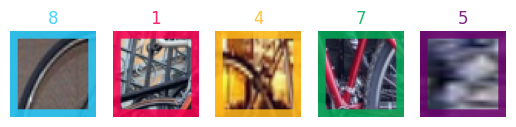

C:\Users\Luca\AppData\Local\Temp\ipykernel_20500\350936687.py:11: RuntimeWarning: invalid value encountered in divide
  img -= img.min();img /= img.max()


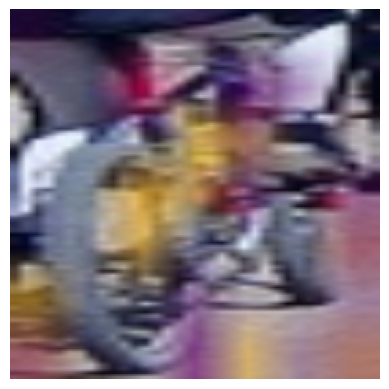

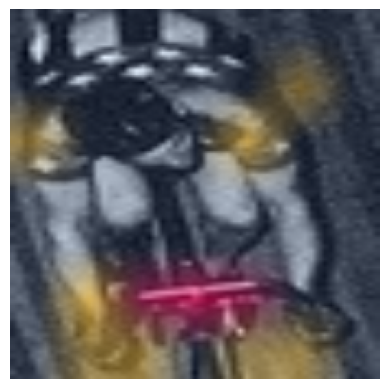

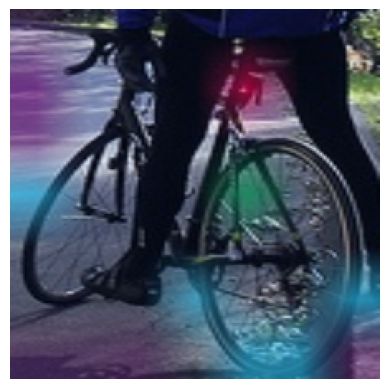

In [24]:
import cv2

def concept_attribution_maps(id, percentile=90):
  img = class_images[id]
  u = images_u[id]

  show(img)

  for i, c_id in enumerate(most_important_concepts):

    cmap = cmaps[i]
    heatmap = u[:, :, c_id]

    # only show concept if excess N-th percentile
    sigma = np.percentile(images_u[:,:,:,c_id].flatten(), percentile)
    heatmap = heatmap * np.array(heatmap > sigma, np.float32)

    heatmap = cv2.resize(heatmap[:, :, None], (224, 224))
    show(heatmap, cmap=cmap, alpha=0.7)

  plt.show()

plot_legend()
concept_attribution_maps(0)
plt.show()
concept_attribution_maps(1)
plt.show()
concept_attribution_maps(2)
plt.show()

In [7]:
import numpy as np

# Define the function
def model(X):
    X1, X2, X3 = X
    return X1 + X2 + X1 * X2 + X3**2

# Monte Carlo parameters
N = 10000  # Number of samples
d = 3  # Number of variables

# Generate random samples for A and B (independent sets)
A = np.random.rand(N, d)
B = np.random.rand(N, d)

# Compute Y values for A and B
YA = np.array([model(A[i]) for i in range(N)])
YB = np.array([model(B[i]) for i in range(N)])

# Compute total variance of Y
VY = np.var(YA)

# First-order and total-order Sobol indices storage
S1 = np.zeros(d)
ST = np.zeros(d)

# Compute Sobol indices for each input
for i in range(d):
    # Create mixed matrix A_Bi (A except the i-th column from B)
    A_Bi = A.copy()
    A_Bi[:, i] = B[:, i]
    
    # Compute Y values for A_Bi
    Y_A_Bi = np.array([model(A_Bi[j]) for j in range(N)])
    
    # First-order Sobol index
    S1[i] = np.cov(YA, Y_A_Bi)[0, 1] / VY  # Covariance approximation
    
    # Total-order Sobol index
    ST[i] = 1 - np.var(Y_A_Bi) / VY

# Print results
for i in range(d):
    print(f"X{i+1}: S1 = {S1[i]:.4f}, ST = {ST[i]:.4f}")

X1: S1 = 0.5964, ST = -0.0166
X2: S1 = 0.5750, ST = 0.0074
X3: S1 = 0.8139, ST = -0.0140


In [2]:
import numpy as np
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_
print(F"X.shape = {X.shape}")
print(F"W.shape = {W.shape}")
print(F"H.shape = {H.shape}")

X.shape = (6, 2)
W.shape = (6, 2)
H.shape = (2, 2)


In [3]:
W @ H

array([[1.00063558, 0.99936347],
       [1.99965977, 1.00034074],
       [2.99965485, 1.20034566],
       [3.9998681 , 1.0001321 ],
       [5.00009002, 0.79990984],
       [6.00008587, 0.999914  ]])